In [36]:
import pandas as pd 
import numpy as np 
import scipy as sp
from scipy.differentiate import derivative # for derivatives
import scipy 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn
import torch.optim as optim
import random
import activationFunctions as af 
from torch.nn.utils.rnn import pad_sequence
import LSTM 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [37]:
df = pd.read_csv('fake_or_real_news.csv')
df

Unnamed: 0                                              title  \
0           8476                       You Can Smell Hillary’s Fear   
1          10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2           3608        Kerry to go to Paris in gesture of sympathy   
3          10142  Bernie supporters on Twitter erupt in anger ag...   
4            875   The Battle of New York: Why This Primary Matters   
...          ...                                                ...   
6330        4490  State Department says it can't find emails fro...   
6331        8062  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...   
6332        8622  Anti-Trump Protesters Are Tools of the Oligarc...   
6333        4021  In Ethiopia, Obama seeks progress on peace, se...   
6334        4330  Jeb Bush Is Suddenly Attacking Trump. Here's W...   

                                                   text label  
0     Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1     Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2     U.S. Secretary of State John F. Kerry said Mon...  REAL  
3     — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4     It's primary day in New York and front-runners...  REAL  
...                                                 ...   ...  
6330  The State Department told the Republican Natio...  REAL  
6331  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...  FAKE  
6332   Anti-Trump Protesters Are Tools of the Oligar...  FAKE  
6333  ADDIS ABABA, Ethiopia —President Obama convene...  REAL  
6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...  REAL  

[6335 rows x 4 columns]

In [38]:

df.drop(labels=['Unnamed: 0'],axis=1,inplace=True)
df.reset_index(drop=True,inplace=True)
df


title  \
0                          You Can Smell Hillary’s Fear   
1     Watch The Exact Moment Paul Ryan Committed Pol...   
2           Kerry to go to Paris in gesture of sympathy   
3     Bernie supporters on Twitter erupt in anger ag...   
4      The Battle of New York: Why This Primary Matters   
...                                                 ...   
6330  State Department says it can't find emails fro...   
6331  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...   
6332  Anti-Trump Protesters Are Tools of the Oligarc...   
6333  In Ethiopia, Obama seeks progress on peace, se...   
6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...   

                                                   text label  
0     Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1     Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2     U.S. Secretary of State John F. Kerry said Mon...  REAL  
3     — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4     It's primary day in New York and front-runners...  REAL  
...                                                 ...   ...  
6330  The State Department told the Republican Natio...  REAL  
6331  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...  FAKE  
6332   Anti-Trump Protesters Are Tools of the Oligar...  FAKE  
6333  ADDIS ABABA, Ethiopia —President Obama convene...  REAL  
6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...  REAL  

[6335 rows x 3 columns]

In [39]:

df_real_all = df[df['label'] == 'REAL']
df_fake_all = df[df['label'] == 'FAKE']

# Wybieram losowo 50% REAL do dfReal 
dfReal = df_real_all.sample(frac=0.5, random_state=42)

# Pozostałe REAL których nie użyto w dfReal
df_remaining_real = df_real_all.drop(dfReal.index)

# dfFake to mix FAKE oraz pozostałych REAL
dfFake = pd.concat([df_fake_all, df_remaining_real]).sample(frac=1, random_state=42).reset_index(drop=True)

dfFake_fake = dfFake[dfFake['label'] == 'FAKE'].sample(frac=0.5, random_state=42)
dfFake_real = dfFake[dfFake['label'] != 'FAKE']
dfFake = pd.concat([dfFake_real, dfFake_fake]).sample(frac=1, random_state=42).reset_index(drop=True)
print(dfFake['label'].value_counts())


label
REAL    1585
FAKE    1582
Name: count, dtype: int64


In [40]:
dfReal.drop(labels=['label'],axis=1,inplace=True)
dfFake.drop(labels=['label'],axis=1,inplace=True)


In [41]:
dfFake

title  \
0     Donald Trump’s RNC 2016 Speech Packed With Lie...   
1     The rest of the field figured out how to make ...   
2                 Rubio’s problem: An excess of caution   
3     PressTV-Yemen’s Hudaydah suffering from dire h...   
4     Clinton Campaign Circulated Paul Ryan Relative...   
...                                                 ...   
3162  Hillary Clinton Attempted To Hack WikiLeaks An...   
3163            Defiant Paul says he can still grow GOP   
3164            GOP Power Rankings: Kasich gets a boost   
3165          Why Jeb Bush’s campaign has gone so wrong   
3166  Defying Republican orthodoxy, Trump trashes tr...   

                                                   text  
0     In Trump’s America, murder is out of control, ...  
1     Something unusual happened here Wednesday when...  
2     Killing Obama administration rules, dismantlin...  
3     Yemen’s Hudaydah suffering from dire humanitar...  
4     Another reason as to why Ryan tried to sabotag...  
...                                                 ...  
3162  Email \nJulian Assange claims that Hillary Cli...  
3163  Since launching his 2016 presidential campaign...  
3164  The Republican presidential race continues to ...  
3165  The Bushes are burning as they consume the new...  
3166  Donald Trump on Tuesday channeled more than a ...  

[3167 rows x 2 columns]

# Tokenization => BPE (Byte Pair Encoding)

In [42]:
max_pair = 255
optmmalization = 5 #łącz w pary do 5 powtórzeń
def convert_text_to_word_bytes(text):
    tokens = text.encode('utf-8')
    tokens = list(map(int, tokens))
    return tokens

dfReal['title_bytes'] = dfReal['title'].apply(convert_text_to_word_bytes)
dfReal['text_bytes'] = dfReal['text'].apply(convert_text_to_word_bytes)

dfFake['title_bytes'] = dfFake['title'].apply(convert_text_to_word_bytes)
dfFake['text_bytes'] = dfFake['text'].apply(convert_text_to_word_bytes)


def get_stats(ids):
    counts = {}
    for id_list in ids:
        for pair in zip(id_list, id_list[1:]):
            counts[pair] = counts.get(pair, 0) + 1
    return counts

RealstatsTitle = get_stats(dfReal['title_bytes'].tolist())
RealstatsText = get_stats(dfReal['text_bytes'].tolist())

FakeStatsText = get_stats(dfFake['text_bytes'].tolist())
FakeStatsTitle = get_stats(dfFake['title_bytes'].tolist())

print(sorted(((v, k) for k, v in RealstatsText.items()), reverse=True))
print(sorted(((v, k) for k, v in RealstatsTitle.items()), reverse=True))

print(sorted(((v, k) for k, v in FakeStatsText.items()), reverse=True))
print(sorted(((v, k) for k, v in FakeStatsTitle.items()), reverse=True))

def createNewList(stats):

    most_common_pair_text = max(stats, key=stats.get)
    print("Najczęściej występująca para:", most_common_pair_text, "o częstotliwości:", stats[most_common_pair_text])

createNewList(RealstatsText)
createNewList(RealstatsTitle)
createNewList(FakeStatsText)
createNewList(FakeStatsTitle)
# first_title = next(iter(statsTitle))
# print(first_title)

[(220854, (101, 32)), (178993, (32, 116)), (151497, (115, 32)), (143572, (116, 104)), (132201, (32, 97)), (131053, (104, 101)), (122375, (105, 110)), (117371, (116, 32)), (109619, (100, 32)), (108512, (110, 32)), (99255, (101, 114)), (92808, (97, 110)), (88540, (111, 110)), (83640, (97, 116)), (83413, (114, 101)), (74429, (32, 115)), (72761, (32, 111)), (69971, (101, 110)), (69373, (32, 105)), (66063, (32, 119)), (64886, (116, 101)), (64471, (121, 32)), (63790, (44, 32)), (63353, (111, 114)), (63122, (114, 32)), (62512, (101, 115)), (60784, (116, 111)), (60604, (116, 105)), (59105, (111, 32)), (58482, (110, 100)), (56421, (110, 116)), (55886, (110, 103)), (55439, (101, 100)), (55284, (32, 99)), (54709, (32, 104)), (54128, (104, 97)), (52671, (97, 114)), (52174, (105, 115)), (51488, (115, 116)), (50790, (97, 108)), (49688, (32, 112)), (48803, (105, 116)), (45098, (32, 98)), (44649, (111, 117)), (44044, (32, 102)), (43074, (108, 105)), (42922, (103, 32)), (41879, (100, 101)), (41874, (11

In [43]:
max_pair = 255
optimization = 65  # maksymalna liczba iteracji łączenia i jest to hiperparametr

def merge_pair_single(token_list, pair_to_merge, new_token):
    new_list = []
    i = 0
    while i < len(token_list):
        if i < len(token_list) - 1 and (token_list[i], token_list[i+1]) == pair_to_merge:
            new_list.append(new_token)
            i += 2
        else:
            new_list.append(token_list[i])
            i += 1
    return new_list

def iterative_merge(token_list, num_iterations, start_token=256):
    new_token = start_token
    current_tokens = token_list
    for _ in range(num_iterations):
        stats = {}
        for pair in zip(current_tokens, current_tokens[1:]):
            stats[pair] = stats.get(pair, 0) + 1
        if not stats:
            break 
        most_common_pair = max(stats, key=stats.get)
        current_tokens = merge_pair_single(current_tokens, most_common_pair, new_token)
        new_token += 1
    return current_tokens

dfReal['text_bytes'] = dfReal['text_bytes'].apply(lambda tokens: iterative_merge(tokens, optimization))
dfReal['title_bytes'] = dfReal['title_bytes'].apply(lambda tokens: iterative_merge(tokens, optimization))

dfFake['text_bytes'] = dfFake['text_bytes'].apply(lambda tokens: iterative_merge(tokens, optimization))
dfFake['title_bytes'] = dfFake['title_bytes'].apply(lambda tokens: iterative_merge(tokens, optimization))


In [44]:
dfReal[dfReal['text_bytes'].apply(lambda x: any(i > 255 for i in x))] #sprawdzenie czy są wartości większe niż 255 (jeżeli są to działa bo mergujemy)

title  \
482                   Going Back to the Future in 2016?   
4313       Dem insiders: Sanders failed to dent Clinton   
1998  Fuming over Ryan, some conservative voices tur...   
1937  Cruz, Trump and Rubio win in Iowa. And now we ...   
642   Trump Will Skip GOP Debate As Feud With Fox Ne...   
...                                                 ...   
902   Supreme Court to consider redefining 'one-pers...   
3253  Fight night: Why the South Carolina showdown c...   
3759  Bergdahl's platoon mates: Head of Joint Chiefs...   
3650  Time to press the presidential candidates on F...   
4761  Lindsey Graham presidential bid bets on foreig...   

                                                   text  \
482   (CNN) Who among the nascent field of 2016 cont...   
4313  Killing Obama administration rules, dismantlin...   
1998  Rep. Mark Meadows (R-N.C.) has been able to co...   
1937  It is always interesting to watch democracy in...   
642   Trump Will Skip GOP Debate As Feud With Fox Ne...   
...                                                 ...   
902   WASHINGTON — The Supreme Court agreed Tuesday ...   
3253  The Fox Business debate here in Charleston isn...   
3759  Army Sgt. Bowe Bergdahl walked away from his b...   
3650  In every presidential campaign, there are issu...   
4761  Washington (CNN) Lindsey Graham is running for...   

                     title_bytes  \
482                        [284]   
4313                       [292]   
1998                       [317]   
1937                       [317]   
642                        [309]   
...                          ...   
902                        [314]   
3253                       [309]   
3759  [320, 258, 50, 48, 48, 57]   
3650                       [310]   
4761                       [304]   

                                             text_bytes  
482   [40, 67, 78, 78, 41, 32, 87, 104, 281, 97, 298...  
4313  [320, 262, 102, 111, 114, 109, 260, 262, 32, 2...  
1998  [307, 278, 77, 287, 107, 32, 77, 297, 100, 111...  
1937  [73, 262, 276, 256, 108, 119, 97, 121, 260, 26...  
642   [306, 87, 105, 317, 83, 107, 105, 112, 32, 71,...  
...                                                 ...  
902   [87, 65, 83, 72, 73, 78, 71, 84, 79, 78, 32, 2...  
3253  [313, 256, 70, 111, 120, 32, 306, 115, 260, 27...  
3759  [65, 114, 109, 271, 83, 103, 116, 284, 66, 296...  
3650  [73, 110, 32, 101, 299, 271, 112, 279, 115, 31...  
4761  [87, 97, 115, 104, 265, 103, 116, 277, 40, 67,...  

[1586 rows x 4 columns]

2988
4943
2610
4189


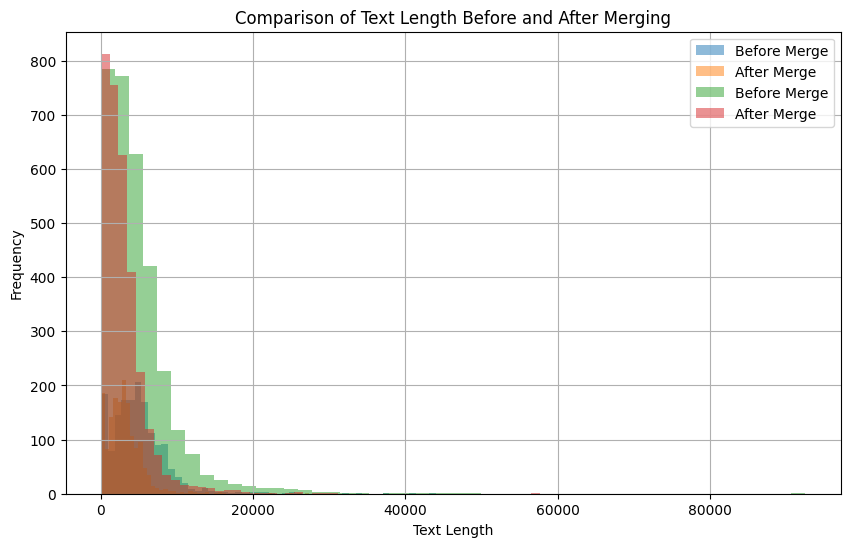

In [45]:
print(len(dfReal['text_bytes'].iloc[0]))
print(len(dfReal['text'].iloc[0]))
print(len(dfFake['text_bytes'].iloc[0]))
print(len(dfFake['text'].iloc[0]))
#porównanie długości tekstu przed i po mergowaniu
plt.figure(figsize=(10, 6))
dfReal['text'].apply(len).hist(bins=50, alpha=0.5, label='Before Merge')  # x: Długość tekstu przed mergowaniem, y: Liczba wystąpień
dfReal['text_bytes'].apply(len).hist(bins=50, alpha=0.5, label='After Merge')  
dfFake['text'].apply(len).hist(bins=50, alpha=0.5, label='Before Merge')  # x: Długość tekstu przed mergowaniem, y: Liczba wystąpień
dfFake['text_bytes'].apply(len).hist(bins=50, alpha=0.5, label='After Merge')  
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Comparison of Text Length Before and After Merging')
plt.legend()
plt.show()


The problem of embeddings is that when training the model with words, converted as numbers. When model is learning on dataset that have two words appering for eg. pair of two words in one sentance. The algorythm catches that and it thing that the words are related. But when the sentence have changed and order of words changes then it leads to missunderstanding. That's where LSTM comes usefull... or even better the BERT algorythm created by google is a breakthoru, but Im not going to focus on that

Why use an embedding when we have a linear layer?

An embedding is an efficient alternative to a single linear layer when one has a large number of input features. This may happen in natural language processing (NLP) when one is working with text data or in some (language-like) tabular data that is treated as a bag-of-words (BoW). In such cases its also quite common to have the input data available as a sparse matrix (typically a result of an output from sklearn’s CountVectorizer of TfidfVectorizer as a sparse.scipy.csr_matrix) and it is memory-inefficent to convert that in to a dense matrix but really easy to access its non-zero elements and their positions directly instead (using the data and indices attributes).

Embedding jest lepsze od Linear definition-wise bo one hot maruje miejsce i nie ma powiązań a embedding dopasowuje itd. Wytłumacz to dokładniej 
Warstwa embedding w modelach NLP służy do przekształcania dyskretnych reprezentacji słów (takich jak indeksy lub one-hot encoding) na gęste wektory, które mają niższą wymiarowość i zachowują relacje semantyczne między słowami.
Embedding to sposób na reprezentację słów jako gęste, niskowymiarowe wektory, które zachowują informacje o relacjach semantycznych między słowami.

One-hot encoding nie posiada tych właściwości, bo tworzy bardzo duże, rzadkie wektory bez relacji między słowami.

Warstwa embedding jest trenowalna – w trakcie uczenia modelu wartości wektorów są dostosowywane, co umożliwia modelowi lepsze rozumienie kontekstu i znaczenia słów.
Dlaczego embedding jest lepszy od one-hot?

    Mniejsza wymiarowość:

        One-hot encoding tworzy bardzo rozległe wektory – jeżeli masz słownik o 10 000 słowach, to każdy słownikowy wektor ma 10 000 wymiarów, z których tylko jeden jest równy 1, a reszta 0.

        Embedding zamienia każde słowo na wektor o stałej, znacznie mniejszej liczbie wymiarów (np. 50, 100 lub 300). To oszczędza pamięć i obliczenia.

    Uczenie relacji między słowami:

        W one-hot encodingu wszystkie wektory są ortogonalne – nie ma między nimi żadnych zależności, nawet jeśli słowa są semantycznie podobne.

        W embeddingach słowa, które występują w podobnych kontekstach, mają podobne wektory. Na przykład wektory słów "pies" i "kot" mogą być do siebie zbliżone, co odzwierciedla ich podobieństwo semantyczne.

    Trenowalność:

        Embeddingi są inicjowane losowo, ale podczas treningu model dostosowuje ich wartości poprzez backpropagation.

        W rezultacie, po treningu, embeddingi zawierają informacje o kontekście i relacjach między słowami – model „uczy się”, że niektóre słowa są podobne, a inne od siebie bardzo różne.

In [46]:
all_tokens = set()
for tokens in dfReal['text_bytes']:
    all_tokens.update(tokens)
for tokens in dfReal['title_bytes']:
    all_tokens.update(tokens)
for tokens in dfFake['title_bytes']:
    all_tokens.update(tokens)
for tokens in dfFake['title_bytes']:
    all_tokens.update(tokens)
    
overall_max = max(all_tokens)
num_embeddings = overall_max + 1
print("Liczba unikalnych tokenów:", num_embeddings)

# Utwórz warstwę embeddingu
embedding_layer = nn.Embedding(num_embeddings, 5)

def embed_text(tokens):
    token_tensor = torch.tensor(tokens, dtype=torch.long)
    embedded = embedding_layer(token_tensor)
    # Upewnij się, że wyłączasz gradienty przed konwersją do numpy
    return embedded.detach().numpy()

# Zastosuj funkcję dla kolumn – przypisujemy numpy arrays
dfReal['embedded_text'] = dfReal['text_bytes'].apply(lambda tokens: embed_text(tokens))
dfReal['embedded_title'] = dfReal['title_bytes'].apply(lambda tokens: embed_text(tokens))
dfFake['embedded_text'] = dfFake['text_bytes'].apply(lambda tokens: embed_text(tokens))
dfFake['embedded_title'] = dfFake['title_bytes'].apply(lambda tokens: embed_text(tokens))
dfReal


Liczba unikalnych tokenów: 321


title  \
482                   Going Back to the Future in 2016?   
4313       Dem insiders: Sanders failed to dent Clinton   
1998  Fuming over Ryan, some conservative voices tur...   
1937  Cruz, Trump and Rubio win in Iowa. And now we ...   
642   Trump Will Skip GOP Debate As Feud With Fox Ne...   
...                                                 ...   
902   Supreme Court to consider redefining 'one-pers...   
3253  Fight night: Why the South Carolina showdown c...   
3759  Bergdahl's platoon mates: Head of Joint Chiefs...   
3650  Time to press the presidential candidates on F...   
4761  Lindsey Graham presidential bid bets on foreig...   

                                                   text  \
482   (CNN) Who among the nascent field of 2016 cont...   
4313  Killing Obama administration rules, dismantlin...   
1998  Rep. Mark Meadows (R-N.C.) has been able to co...   
1937  It is always interesting to watch democracy in...   
642   Trump Will Skip GOP Debate As Feud With Fox Ne...   
...                                                 ...   
902   WASHINGTON — The Supreme Court agreed Tuesday ...   
3253  The Fox Business debate here in Charleston isn...   
3759  Army Sgt. Bowe Bergdahl walked away from his b...   
3650  In every presidential campaign, there are issu...   
4761  Washington (CNN) Lindsey Graham is running for...   

                     title_bytes  \
482                        [284]   
4313                       [292]   
1998                       [317]   
1937                       [317]   
642                        [309]   
...                          ...   
902                        [314]   
3253                       [309]   
3759  [320, 258, 50, 48, 48, 57]   
3650                       [310]   
4761                       [304]   

                                             text_bytes  \
482   [40, 67, 78, 78, 41, 32, 87, 104, 281, 97, 298...   
4313  [320, 262, 102, 111, 114, 109, 260, 262, 32, 2...   
1998  [307, 278, 77, 287, 107, 32, 77, 297, 100, 111...   
1937  [73, 262, 276, 256, 108, 119, 97, 121, 260, 26...   
642   [306, 87, 105, 317, 83, 107, 105, 112, 32, 71,...   
...                                                 ...   
902   [87, 65, 83, 72, 73, 78, 71, 84, 79, 78, 32, 2...   
3253  [313, 256, 70, 111, 120, 32, 306, 115, 260, 27...   
3759  [65, 114, 109, 271, 83, 103, 116, 284, 66, 296...   
3650  [73, 110, 32, 101, 299, 271, 112, 279, 115, 31...   
4761  [87, 97, 115, 104, 265, 103, 116, 277, 40, 67,...   

                                          embedded_text  \
482   [[0.3879449, 1.0293585, -0.5915, -2.6370075, 0...   
4313  [[0.3841276, 0.49589926, 0.3316439, 0.64669865...   
1998  [[0.011760553, 1.2233993, 0.7064244, 0.7468939...   
1937  [[0.16345832, 1.5267307, 1.2276511, 0.22959499...   
642   [[0.15593912, 0.05685857, 1.427278, 1.4249367,...   
...                                                 ...   
902   [[-1.0437738, -0.70677507, 0.14304546, 0.37873...   
3253  [[-0.07435758, 1.2399144, -0.7798541, 0.057933...   
3759  [[-0.9194829, -0.22231162, 0.5886526, 0.533887...   
3650  [[0.16345832, 1.5267307, 1.2276511, 0.22959499...   
4761  [[-1.0437738, -0.70677507, 0.14304546, 0.37873...   

                                         embedded_title  
482   [[0.78463346, 0.069772154, 1.4453214, 1.120515...  
4313  [[-2.2147794, -1.109803, 0.15686157, 0.8262859...  
1998  [[0.9872286, -0.44125548, -0.6323272, 1.107005...  
1937  [[0.9872286, -0.44125548, -0.6323272, 1.107005...  
642   [[-0.8249274, 0.67964274, -2.118603, -0.333945...  
...                                                 ...  
902   [[1.2565821, 0.9378527, 0.024884423, 0.5214551...  
3253  [[-0.8249274, 0.67964274, -2.118603, -0.333945...  
3759  [[0.3841276, 0.49589926, 0.3316439, 0.64669865...  
3650  [[-0.08508517, 1.1595654, -1.5720571, 0.481622...  
4761  [[-0.21925059, -0.14171322, -1.3069639, 0.0701...  

[1586 rows x 6 columns]

# LSTM 


In [47]:

class LSTM:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Inicjalizacja wag i biasów (każde mnożone przez 0.01)
        self.Wf = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bf = np.zeros((hidden_size, 1))
        self.Wi = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bi = np.zeros((hidden_size, 1))
        self.Wc = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bc = np.zeros((hidden_size, 1))
        self.Wo = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bo = np.zeros((hidden_size, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def forward(self, x, h_prev, c_prev):
        # x: (input_size, 1), h_prev: (hidden_size, 1), c_prev: (hidden_size, 1)
        concat = np.vstack((h_prev, x))  # kształt: (hidden_size + input_size, 1)

        # Forget gate
        ft = self.sigmoid(np.dot(self.Wf, concat) + self.bf)
        # Input gate
        it = self.sigmoid(np.dot(self.Wi, concat) + self.bi)
        c_tilde = self.tanh(np.dot(self.Wc, concat) + self.bc)
        # Aktualizacja stanu komórkowego
        ct = ft * c_prev + it * c_tilde
        # Output gate
        ot = self.sigmoid(np.dot(self.Wo, concat) + self.bo)
        ht = ot * self.tanh(ct)
        return ht, ct

    def forward_sequence(self, x_seq, h0=None, c0=None):
        """
        Przetwarza całą sekwencję.
        x_seq: numpy array o kształcie (seq_len, input_size)
        Zwraca:
          outputs: lista stanów ukrytych dla każdego kroku (kształt: (hidden_size, seq_len))
          h_final, c_final: końcowe stany
        """
        seq_len = x_seq.shape[0]
        if h0 is None:
            h = np.zeros((self.hidden_size, 1))
        else:
            h = h0
        if c0 is None:
            c = np.zeros((self.hidden_size, 1))
        else:
            c = c0

        outputs = []
        for t in range(seq_len):
            x_t = x_seq[t].reshape(-1, 1)
            h, c = self.forward(x_t, h, c)
            outputs.append(h)
        outputs = np.concatenate(outputs, axis=1)  # (hidden_size, seq_len)
        return outputs, h, c

class LSTMWithAttention(LSTM):
    def __init__(self, input_size, hidden_size):
        super().__init__(input_size, hidden_size)
        # Inicjujemy parametry dla mechanizmu attention.
        # Używamy prostej uwagi, która liczy skalarne score dla każdego stanu ukrytego.
        # Wektor W_a o wymiarze (1, hidden_size) i bias b_a (1, 1)
        self.W_a = np.random.randn(1, hidden_size) * 0.01
        self.b_a = np.zeros((1, 1))
    
    def softmax(self, x):
        # x: (1, seq_len)
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward_with_attention(self, x_seq, h0=None, c0=None):
        """
        Przetwarza całą sekwencję przez LSTM, a następnie stosuje mechanizm attention.
        Zwraca:
          context_vector: ważona suma stanów ukrytych (kontekst) – (hidden_size, 1)
          att_weights: wagi attention dla każdego kroku – (1, seq_len)
          h_final, c_final: końcowe stany LSTM
        """
        # Najpierw przetwarzamy sekwencję przez LSTM
        outputs, h_final, c_final = self.forward_sequence(x_seq, h0, c0)  # outputs: (hidden_size, seq_len)
        
        # Obliczamy score dla każdego stanu ukrytego:
        # scores = tanh(W_a * h + b_a)
        scores = np.tanh(np.dot(self.W_a, outputs) + self.b_a)  # (1, seq_len)
        att_weights = self.softmax(scores)  # (1, seq_len)
        
        # Obliczamy kontekst jako sumę ważoną stanów ukrytych
        context_vector = np.sum(outputs * att_weights, axis=1, keepdims=True)  # (hidden_size, 1)
        return context_vector, att_weights, h_final, c_final

# Przykładowe użycie dla całego zbioru danych:

# Załóżmy, że df['embedded_text'] zawiera osadzenia tekstu jako numpy arrays o kształcie (seq_len, 5)
# Ustawienia:
input_size = 5     # wymiar embeddingu
hidden_size = 20   # liczba jednostek w LSTM

# Inicjalizacja modelu LSTM z attention
model = LSTMWithAttention(input_size, hidden_size)

def process_sequence(seq):
    # seq: numpy array o kształcie (seq_len, input_size)
    context_vector, att_weights, h_final, c_final = model.forward_with_attention(seq)
    return context_vector  # Możesz zwrócić również att_weights, jeśli chcesz analizować wagi

# Przetwarzamy wszystkie wiersze DataFrame
final_representations = []
for i in range(len(dfReal)):
    seq = dfReal['embedded_text'].iloc[i]  # (seq_len, 5)
    context_vector = process_sequence(seq)
    final_representations.append(context_vector)
    print(f"Row {i}: Context vector shape: {context_vector.shape}")

dfReal['final_hidden_state'] = final_representations

print("Przykładowe finalne reprezentacje:")
for rep in dfReal['final_hidden_state'].head():
    print(rep)


Row 0: Context vector shape: (20, 1)
Row 1: Context vector shape: (20, 1)
Row 2: Context vector shape: (20, 1)
Row 3: Context vector shape: (20, 1)
Row 4: Context vector shape: (20, 1)
Row 5: Context vector shape: (20, 1)
Row 6: Context vector shape: (20, 1)
Row 7: Context vector shape: (20, 1)
Row 8: Context vector shape: (20, 1)
Row 9: Context vector shape: (20, 1)
Row 10: Context vector shape: (20, 1)
Row 11: Context vector shape: (20, 1)
Row 12: Context vector shape: (20, 1)
Row 13: Context vector shape: (20, 1)
Row 14: Context vector shape: (20, 1)
Row 15: Context vector shape: (20, 1)
Row 16: Context vector shape: (20, 1)
Row 17: Context vector shape: (20, 1)
Row 18: Context vector shape: (20, 1)
Row 19: Context vector shape: (20, 1)
Row 20: Context vector shape: (20, 1)
Row 21: Context vector shape: (20, 1)
Row 22: Context vector shape: (20, 1)
Row 23: Context vector shape: (20, 1)
Row 24: Context vector shape: (20, 1)
Row 25: Context vector shape: (20, 1)
Row 26: Context vector

In [48]:

#LSTM
input_size = 5       # musi być zgodne z wymiarem embeddingu
hidden_size = 20     # liczba jednostek ukrytych w LSTM
lstm = LSTM(input_size, hidden_size)

# Funkcja przetwarzająca jedną sekwencję
def process_sequence(seq):
    # seq to numpy array o kształcie (seq_len, input_size)
    outputs, h_final, c_final = lstm.forward_sequence(seq)
    return h_final  # zwracamy ostateczny stan ukryty jako reprezentację sekwencji

# Iterujemy po całym DataFrame dla kolumny 'embedded_text'
final_hidden_states_text = []
for i in range(len(dfReal)):
    seq = dfReal['embedded_text'].iloc[i]  # numpy array o kształcie (seq_len, 5)
    # Możesz też dodać warunki paddingu lub przycinania, jeśli sekwencje mają bardzo różne długości
    h_final = process_sequence(seq)
    final_hidden_states_text.append(h_final)
    print(f"Row {i}: Final hidden state text shape: {h_final.shape}")
final_hidden_states_title = []
for i in range(len(dfReal)):
    seq = dfReal['embedded_title'].iloc[i]  # numpy array o kształcie (seq_len, 5)
    h_final = process_sequence(seq)
    final_hidden_states_title.append(h_final)
    print(f"Row {i}: Final hidden state title shape: {h_final.shape}")
# Dodajemy wynik do DataFrame (opcjonalnie konwertując do np. listy)
dfReal['final_hidden_state_text'] = final_hidden_states_text
dfReal['final_hidden_state_title'] = final_hidden_states_title

Row 0: Final hidden state text shape: (20, 1)
Row 1: Final hidden state text shape: (20, 1)
Row 2: Final hidden state text shape: (20, 1)
Row 3: Final hidden state text shape: (20, 1)
Row 4: Final hidden state text shape: (20, 1)
Row 5: Final hidden state text shape: (20, 1)
Row 6: Final hidden state text shape: (20, 1)
Row 7: Final hidden state text shape: (20, 1)
Row 8: Final hidden state text shape: (20, 1)
Row 9: Final hidden state text shape: (20, 1)
Row 10: Final hidden state text shape: (20, 1)
Row 11: Final hidden state text shape: (20, 1)
Row 12: Final hidden state text shape: (20, 1)
Row 13: Final hidden state text shape: (20, 1)
Row 14: Final hidden state text shape: (20, 1)
Row 15: Final hidden state text shape: (20, 1)
Row 16: Final hidden state text shape: (20, 1)
Row 17: Final hidden state text shape: (20, 1)
Row 18: Final hidden state text shape: (20, 1)
Row 19: Final hidden state text shape: (20, 1)
Row 20: Final hidden state text shape: (20, 1)
Row 21: Final hidden st

In [49]:
dfReal 

title  \
482                   Going Back to the Future in 2016?   
4313       Dem insiders: Sanders failed to dent Clinton   
1998  Fuming over Ryan, some conservative voices tur...   
1937  Cruz, Trump and Rubio win in Iowa. And now we ...   
642   Trump Will Skip GOP Debate As Feud With Fox Ne...   
...                                                 ...   
902   Supreme Court to consider redefining 'one-pers...   
3253  Fight night: Why the South Carolina showdown c...   
3759  Bergdahl's platoon mates: Head of Joint Chiefs...   
3650  Time to press the presidential candidates on F...   
4761  Lindsey Graham presidential bid bets on foreig...   

                                                   text  \
482   (CNN) Who among the nascent field of 2016 cont...   
4313  Killing Obama administration rules, dismantlin...   
1998  Rep. Mark Meadows (R-N.C.) has been able to co...   
1937  It is always interesting to watch democracy in...   
642   Trump Will Skip GOP Debate As Feud With Fox Ne...   
...                                                 ...   
902   WASHINGTON — The Supreme Court agreed Tuesday ...   
3253  The Fox Business debate here in Charleston isn...   
3759  Army Sgt. Bowe Bergdahl walked away from his b...   
3650  In every presidential campaign, there are issu...   
4761  Washington (CNN) Lindsey Graham is running for...   

                     title_bytes  \
482                        [284]   
4313                       [292]   
1998                       [317]   
1937                       [317]   
642                        [309]   
...                          ...   
902                        [314]   
3253                       [309]   
3759  [320, 258, 50, 48, 48, 57]   
3650                       [310]   
4761                       [304]   

                                             text_bytes  \
482   [40, 67, 78, 78, 41, 32, 87, 104, 281, 97, 298...   
4313  [320, 262, 102, 111, 114, 109, 260, 262, 32, 2...   
1998  [307, 278, 77, 287, 107, 32, 77, 297, 100, 111...   
1937  [73, 262, 276, 256, 108, 119, 97, 121, 260, 26...   
642   [306, 87, 105, 317, 83, 107, 105, 112, 32, 71,...   
...                                                 ...   
902   [87, 65, 83, 72, 73, 78, 71, 84, 79, 78, 32, 2...   
3253  [313, 256, 70, 111, 120, 32, 306, 115, 260, 27...   
3759  [65, 114, 109, 271, 83, 103, 116, 284, 66, 296...   
3650  [73, 110, 32, 101, 299, 271, 112, 279, 115, 31...   
4761  [87, 97, 115, 104, 265, 103, 116, 277, 40, 67,...   

                                          embedded_text  \
482   [[0.3879449, 1.0293585, -0.5915, -2.6370075, 0...   
4313  [[0.3841276, 0.49589926, 0.3316439, 0.64669865...   
1998  [[0.011760553, 1.2233993, 0.7064244, 0.7468939...   
1937  [[0.16345832, 1.5267307, 1.2276511, 0.22959499...   
642   [[0.15593912, 0.05685857, 1.427278, 1.4249367,...   
...                                                 ...   
902   [[-1.0437738, -0.70677507, 0.14304546, 0.37873...   
3253  [[-0.07435758, 1.2399144, -0.7798541, 0.057933...   
3759  [[-0.9194829, -0.22231162, 0.5886526, 0.533887...   
3650  [[0.16345832, 1.5267307, 1.2276511, 0.22959499...   
4761  [[-1.0437738, -0.70677507, 0.14304546, 0.37873...   

                                         embedded_title  \
482   [[0.78463346, 0.069772154, 1.4453214, 1.120515...   
4313  [[-2.2147794, -1.109803, 0.15686157, 0.8262859...   
1998  [[0.9872286, -0.44125548, -0.6323272, 1.107005...   
1937  [[0.9872286, -0.44125548, -0.6323272, 1.107005...   
642   [[-0.8249274, 0.67964274, -2.118603, -0.333945...   
...                                                 ...   
902   [[1.2565821, 0.9378527, 0.024884423, 0.5214551...   
3253  [[-0.8249274, 0.67964274, -2.118603, -0.333945...   
3759  [[0.3841276, 0.49589926, 0.3316439, 0.64669865...   
3650  [[-0.08508517, 1.1595654, -1.5720571, 0.481622...   
4761  [[-0.21925059, -0.14171322, -1.3069639, 0.0701...   

                                     final_hidden_state  \
482   [[-0.00

In [50]:
combined_embeddings = torch.cat(
    [torch.stack([torch.tensor(x) for x in dfReal['final_hidden_state_title'].tolist()]), 
     torch.stack([torch.tensor(x) for x in dfReal['final_hidden_state_text'].tolist()])], 
    dim=0
)



In [ ]:
combined_embeddings[0]

tensor([[[ 1.5337e-03],
         [-2.8895e-03],
         [ 8.8483e-03],
         [ 9.6166e-04],
         [-8.4332e-03],
         [ 6.3959e-03],
         [ 2.3561e-03],
         [ 3.5640e-03],
         [ 3.2774e-03],
         [ 3.1819e-03],
         [-2.2670e-04],
         [-1.9976e-03],
         [-1.8976e-03],
         [-2.5667e-03],
         [-8.4405e-03],
         [-3.4969e-03],
         [-7.1906e-03],
         [ 4.7136e-03],
         [-2.8168e-03],
         [ 1.8083e-04]],

        [[ 1.9410e-02],
         [ 9.4871e-04],
         [ 7.6250e-03],
         [-5.3179e-03],
         [ 1.4178e-02],
         [-1.5494e-03],
         [ 8.5281e-03],
         [ 8.6516e-03],
         [-6.7528e-04],
         [-2.4592e-02],
         [-1.6955e-03],
         [ 6.0926e-03],
         [-4.0574e-03],
         [ 1.1152e-03],
         [-1.0671e-02],
         [ 6.5328e-03],
         [-5.7178e-03],
         [ 3.7019e-03],
         [-8.2292e-03],
         [ 6.8437e-03]],

        [[ 4.9541e-03],
         [ 3

# Layer Normalization

In [58]:
# Layer normalization nie działa zbyt poprawnie dlatego przetestuję bez niego :) 

# Jednak chyba działa

In [ ]:
combined_embeddings = combined_embeddings.float()
layer_norm = nn.LayerNorm(normalized_shape=combined_embeddings.size()[1:])
normalized_embeddings = layer_norm(combined_embeddings)
print("Normalized embeddings:", normalized_embeddings) 

Normalized embeddings: tensor([[[ 0.3200],
         [-0.4748],
         [ 1.6343],
         ...,
         [ 0.8914],
         [-0.4617],
         [ 0.0769]],

        [[ 1.8479],
         [-0.0108],
         [ 0.6613],
         ...,
         [ 0.2664],
         [-0.9348],
         [ 0.5827]],

        [[ 1.3123],
         [ 0.2424],
         [ 0.2791],
         ...,
         [-0.0399],
         [ 0.1621],
         [ 0.6177]],

        ...,

        [[ 0.4816],
         [-0.1262],
         [-0.2991],
         ...,
         [ 0.2615],
         [-0.6272],
         [ 1.0485]],

        [[ 0.1725],
         [-0.1803],
         [-0.4678],
         ...,
         [ 0.2798],
         [-0.3321],
         [ 1.1475]],

        [[-0.0708],
         [-0.6380],
         [ 0.3404],
         ...,
         [ 0.8880],
         [-0.8587],
         [ 1.0559]]], grad_fn=<NativeLayerNormBackward0>)


In [ ]:
normalized_embeddings[0]

tensor([[[ 0.3200],
         [-0.4748],
         [ 1.6343],
         [ 0.2172],
         [-1.4709],
         [ 1.1937],
         [ 0.4678],
         [ 0.6848],
         [ 0.6333],
         [ 0.6162],
         [ 0.0037],
         [-0.3145],
         [-0.2966],
         [-0.4168],
         [-1.4722],
         [-0.5840],
         [-1.2477],
         [ 0.8914],
         [-0.4617],
         [ 0.0769]],

        [[ 1.8479],
         [-0.0108],
         [ 0.6613],
         [-0.6417],
         [ 1.3211],
         [-0.2623],
         [ 0.7523],
         [ 0.7647],
         [-0.1743],
         [-2.5822],
         [-0.2770],
         [ 0.5071],
         [-0.5148],
         [ 0.0059],
         [-1.1806],
         [ 0.5514],
         [-0.6820],
         [ 0.2664],
         [-0.9348],
         [ 0.5827]],

        [[ 1.3123],
         [ 0.2424],
         [ 0.2791],
         [ 0.0147],
         [ 0.1826],
         [-1.1777],
         [-0.6619],
         [ 0.0750],
         [ 0.2150],
         [ 0.424

# AnoGAN

In [30]:

# Ustawienia hiperparametrów
latent_dim = 100          # Wymiar wektora latentnego (szum)
embedding_dim = 50        # Wymiar reprezentacji tekstu (np. wynik embeddingu)
seq_len = 200             # Stała długość sekwencji (może być wynikiem pad-sequence)
hidden_dim = 128          # Liczba jednostek w warstwach ukrytych
batch_size = 64

# Generator: przekształca szum w sekwencję embeddingów (tu uproszczony model LSTM)
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, embedding_dim, seq_len):
        super(Generator, self).__init__()
        self.seq_len = seq_len
        self.fc = nn.Linear(latent_dim, hidden_dim * seq_len)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, embedding_dim)
    
    def forward(self, z):
        # z: (batch_size, latent_dim)
        x = self.fc(z)  # (batch_size, hidden_dim * seq_len)
        x = x.view(-1, self.seq_len, hidden_dim)  # (batch_size, seq_len, hidden_dim)
        lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_dim)
        output = self.output_layer(lstm_out)  # (batch_size, seq_len, embedding_dim)
        return output

# Dyskryminator: ocenia czy sekwencja embeddingów pochodzi z prawdziwych danych
class Discriminator(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, seq_len):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)  # bidirectional → 2*hidden_dim
        
    def forward(self, x):
        # x: (batch_size, seq_len, embedding_dim)
        lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_dim*2)
        # Używamy ostatniego stanu (lub możemy uśrednić wyjścia) 
        # Tutaj uśredniamy po czasie:
        features = torch.mean(lstm_out, dim=1)  # (batch_size, hidden_dim*2)
        output = self.fc(features)  # (batch_size, 1)
        return torch.sigmoid(output)  # prawdopodobieństwo, że dane są prawdziwe

# Inicjalizacja modeli
generator = Generator(latent_dim, hidden_dim, embedding_dim, seq_len)
discriminator = Discriminator(embedding_dim, hidden_dim, seq_len)

# Optymalizatory
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function (binary cross entropy)
criterion = nn.BCELoss()

# Przygotuj dane treningowe – zakładamy, że masz tensor `real_data`
# o wymiarach (batch_size, seq_len, embedding_dim) dla prawdziwych artykułów
# W praktyce użyjesz DataLoadera, aby karmić model partiami.
# Tu przykład jednej iteracji treningu:

def train_step(real_data):
    batch_size = real_data.size(0)
    
    # Etykiety: 1 dla prawdziwych, 0 dla fałszywych
    valid = torch.ones(batch_size, 1)
    fake = torch.zeros(batch_size, 1)
    
    ## Trening dyskryminatora
    optimizer_D.zero_grad()
    
    # Real data loss
    real_preds = discriminator(real_data)
    loss_real = criterion(real_preds, valid)
    
    # Generowanie fałszywych danych
    z = torch.randn(batch_size, latent_dim)
    gen_data = generator(z)
    
    # Fake data loss
    fake_preds = discriminator(gen_data.detach())
    loss_fake = criterion(fake_preds, fake)
    
    loss_D = (loss_real + loss_fake) / 2
    loss_D.backward()
    optimizer_D.step()
    
    ## Trening generatora
    optimizer_G.zero_grad()
    
    # Generator chce oszukać dyskryminatora
    fake_preds = discriminator(gen_data)
    loss_G = criterion(fake_preds, valid)
    loss_G.backward()
    optimizer_G.step()
    
    return loss_D.item(), loss_G.item()

# Przykładowy trening
num_epochs = 10
for epoch in range(num_epochs):
    # Tu pobierasz batch danych (real_data) z DataLoadera – poniżej przykład z losowym tensorem
    real_data = torch.randn(batch_size, seq_len, embedding_dim)  # symulacja prawdziwych danych
    loss_D, loss_G = train_step(real_data)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss_D: {loss_D:.4f}, Loss_G: {loss_G:.4f}")


Epoch 1/10 - Loss_D: 0.6922, Loss_G: 0.6771
Epoch 2/10 - Loss_D: 0.6907, Loss_G: 0.6803
Epoch 3/10 - Loss_D: 0.6899, Loss_G: 0.6835
Epoch 4/10 - Loss_D: 0.6885, Loss_G: 0.6869
Epoch 5/10 - Loss_D: 0.6872, Loss_G: 0.6901
Epoch 6/10 - Loss_D: 0.6862, Loss_G: 0.6932
Epoch 7/10 - Loss_D: 0.6854, Loss_G: 0.6964
Epoch 8/10 - Loss_D: 0.6842, Loss_G: 0.6999
Epoch 9/10 - Loss_D: 0.6828, Loss_G: 0.7030
Epoch 10/10 - Loss_D: 0.6826, Loss_G: 0.7060
